In [43]:
# Import 3rd party packages

using DifferentialEquations, StochasticDiffEq, LinearAlgebra, Calculus, Discretizers, KernelDensity, Distributions
using JLD2, FileIO, DataFrames, LaTeXStrings;
using DelimitedFiles,CSV, Query;
using Plots;

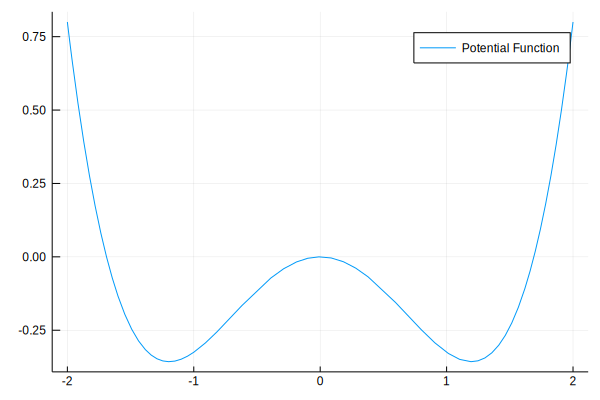

In [44]:
#########################################
# Potential function (V): 
# (a*x^4)/4 - (b*x^3)/3 - (c*x^2)/2 - d*x
#########################################

a1=0.7
b1=0.0
c1=1.0
d1=0.0

f(x) = (a1*x^4)/4 - (b1*x^3)/3 - (c1*x^2)/2 - d1*x

plot(f, -2.0, 2.0, label=("Potential Function"))

In [45]:
##################################
######## SDE FUNCTION ITO ########
##################################
function sde_ito(x₀, α, a, c)
    b=0.0
    d=0.0
    f(x,p,t) = -a*x^3+b*x^2+c*x+d
    g(x,p,t) = α*x
    tspan = (0.0,10.0) 
    prob = SDEProblem(f,g,x₀,tspan)
    saveat = 0.001
    sol = solve(prob,alg_hints=[:stiff],saveat=saveat)
    return sol
end
##################################

sde_ito (generic function with 1 method)

In [46]:
##################################
######## SDE FUNCTION ITO ########
##################################
function sde_stran(x₀, α, a, c)
    b=0.0
    d=0.0
    f(x,p,t) = -a*x^3+b*x^2+c*x+d
    g(x,p,t) = α*x
    tspan = (0.0,10.0) 
    prob = SDEProblem(f,g,x₀,tspan)
    dt = 0.001
    sol = solve(prob,EulerHeun(),alg_hints=[:stiff],dt=dt)
    return sol
end
##################################

sde_stran (generic function with 1 method)

In [68]:
##################################
########### SIMULATION ###########
##################################

# Define some parameters

# Define noise term here
α=0.5
# Create an array of initial conditions [start:step_size:stop]
# Is it worth having such a small step size??? - Investigate (0.1 vs. 0.01)
in_cond = collect(-2.0:0.1:2.0)
# Number of iterations per initial condition
# Is it worth having more iterations - investigate (100 vs. 1000)
iter = 100
# Values of c parameter to use when solving the SDE
params = [a1,c1]

# Generate data according to 4 different functions (4 different values for c parameter)

# Array of solutions for each function
all_sols_ito = Array{RODESolution,2}(undef,iter,length(in_cond))
all_sols_stran = Array{RODESolution,2}(undef,iter,length(in_cond));

In [69]:
##################################
######### SIMULATION ITO #########
##################################

######################################################
# Loop over each initial starting condition
for temp_init in 1:length(in_cond)    
    # Run this code iter times for each starting condition
    for temp_iter in 1:iter
        sol_i = sde_ito(in_cond[temp_init],α,params[1],params[2])
        all_sols_ito[temp_iter, temp_init] = sol_i              
    end
end
######################################################

In [70]:
##################################
######## SIMULATION STRAN ########
##################################

######################################################
# Loop over each initial starting condition
for temp_init in 1:length(in_cond)    
    # Run this code iter times for each starting condition
    for temp_iter in 1:iter
        sol_i = sde_stran(in_cond[temp_init],α,params[1],params[2])
        all_sols_stran[temp_iter, temp_init] = sol_i              
    end
end
######################################################

In [71]:
"""
Generate a normalized pdf from continuous data.
"""
function genkde(data)

    filter!(x -> !isnan(x), data)    # Remove nans from data

    kdeObj = kde(data)
    x = collect(range(minimum(data),stop=maximum(data),length=10000)) # length must: tspan[2]/saveat 
    y_1 = map(z->pdf(kdeObj,z),x)
#     y = log.(y_1)
    y = y_1

    return (x,y)

end

genkde

In [72]:
plot_step_size = 10;

# Generate continious data from all_sols for use in univariate kde per function
# data contains every 10th value for all timepoints 

data_ito = Array{Float64, 1}()
for ii in 1:length(in_cond)
    for jj in 1:iter
        data_ito = vcat(data_ito, all_sols_ito[jj,ii].u[1:plot_step_size:end])
    end
end

data_stran = Array{Float64, 1}()
for ii in 1:length(in_cond)
    for jj in 1:iter
        data_stran = vcat(data_stran, all_sols_stran[jj,ii].u[1:plot_step_size:end])
    end
end

In [73]:
x1,y1 = genkde(data_ito)
x2,y2 = genkde(data_stran);

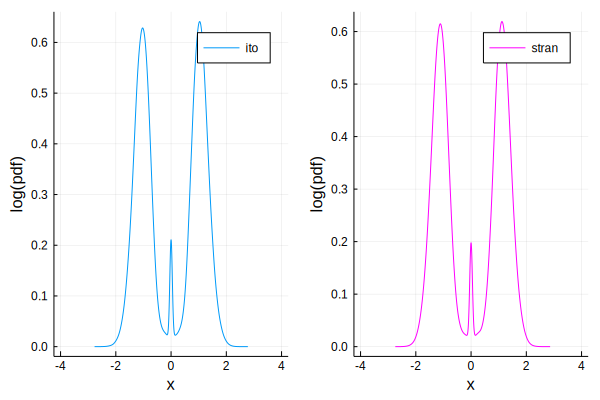

In [74]:
p1 = plot(x1,y1,xlabel="x",ylabel="log(pdf)")
p2 = plot(x2,y2,xlabel="x",ylabel="log(pdf)",color="magenta")
fig = plot(p1,p2,label=["ito" "stran"],xlims=[-4,4])

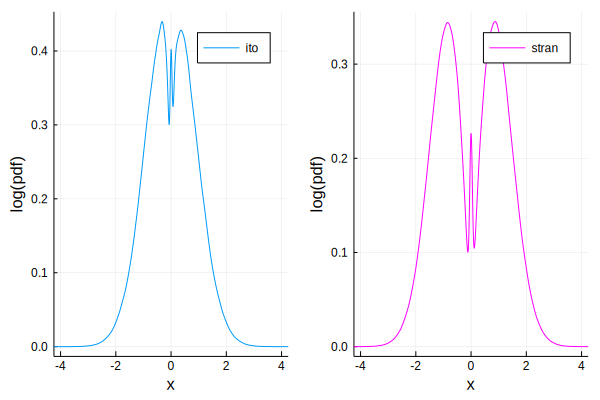

In [53]:
p1 = plot(x1,y1,xlabel="x",ylabel="log(pdf)")
p2 = plot(x2,y2,xlabel="x",ylabel="log(pdf)",color="magenta")
fig = plot(p1,p2,label=["ito" "stran"],xlims=[-4,4])

# Here we can see that as the noise is increased, if the integral is solved according to ito type calculus then
# we observe noise-induced drift

# If we solve the integral with Stran-type calculus then it appears as if there is no noise-induced drift
# introduced

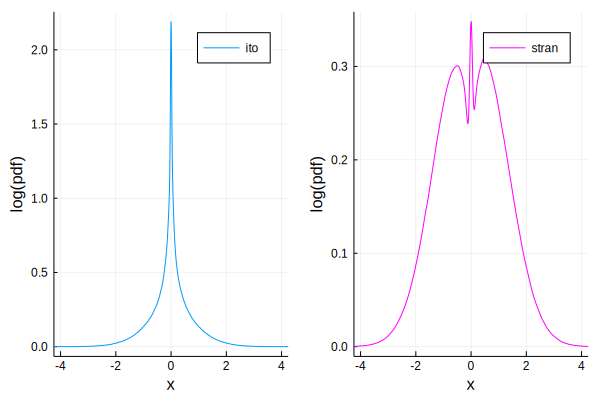

In [60]:
p1 = plot(x1,y1,xlabel="x",ylabel="log(pdf)")
p2 = plot(x2,y2,xlabel="x",ylabel="log(pdf)",color="magenta")
fig = plot(p1,p2,label=["ito" "stran"],xlims=[-4,4])

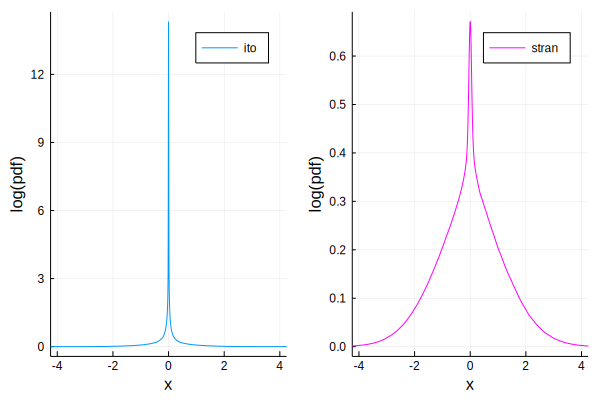

In [67]:
p1 = plot(x1,y1,xlabel="x",ylabel="log(pdf)")
p2 = plot(x2,y2,xlabel="x",ylabel="log(pdf)",color="magenta")
fig = plot(p1,p2,label=["ito" "stran"],xlims=[-4,4])